In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
special_probs = {"break": 0.5, "combine": 0.5}
#special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

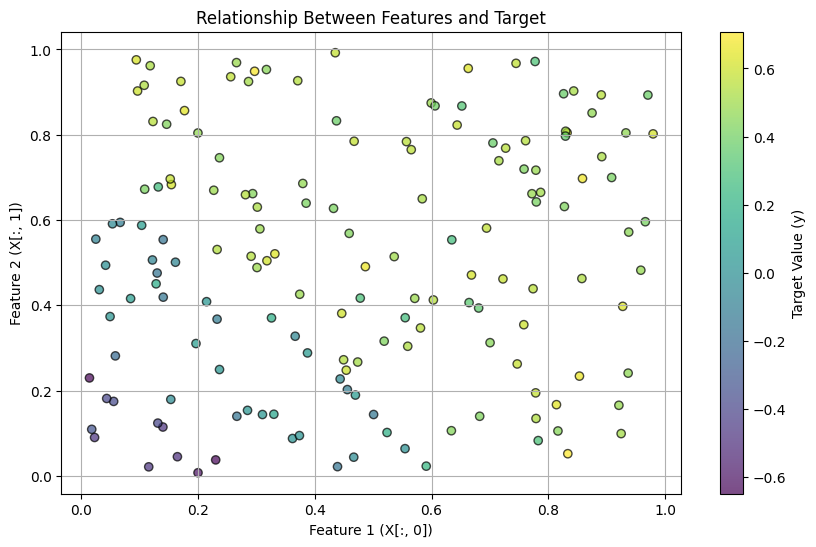

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

In [4]:
bart = ChangeNumTreeBART(ndpost=2000, nskip=2000, n_trees=100, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 100, theta_df = np.inf, 
                         tree_num_prior_type="poisson")
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 4000/4000 [01:13<00:00, 54.27it/s] 


In [5]:
bart.trace[-1].n_trees

43

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00168084]), 'ntree_theta': 100}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

41.829

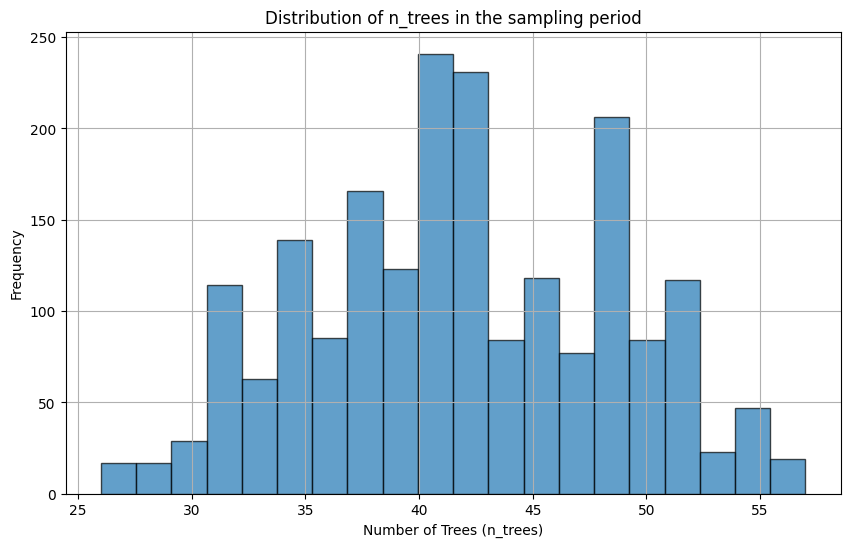

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

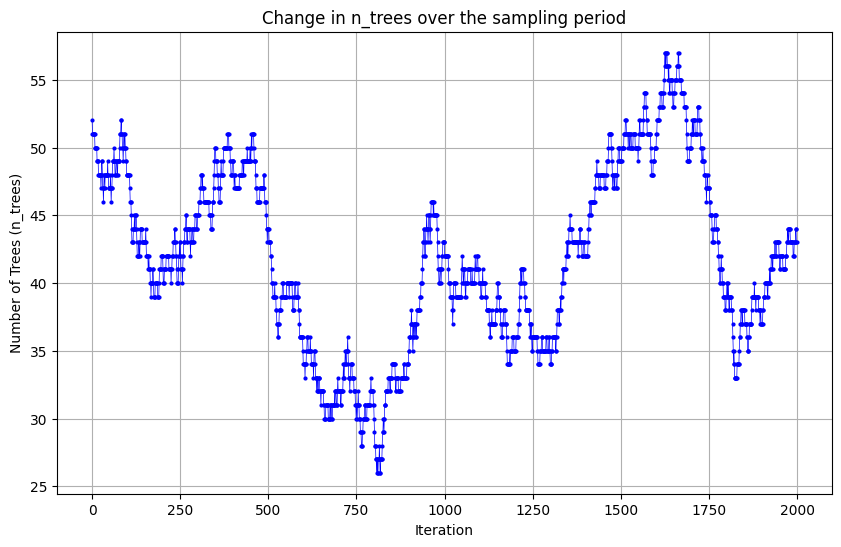

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-15 17:42:57,754:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-15 17:42:57,760:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.42 P_prune=0.58 A_grow=0.50 A_prune=0.28 (burnin)
Iteration 200/300 P_grow=0.47 P_prune=0.53 A_grow=0.35 A_prune=0.09
Iteration 300/300 P_grow=0.51 P_prune=0.49 A_grow=0.23 A_prune=0.24


In [11]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.26619038472882295,
 'rf': 0.021929859292031957,
 'lr': 0.048045521328019404,
 'btz': 0.024621623307740342}

In [12]:
bart.trace[-1].trees

[Tree(vars=[ 0 -1 -1 -2], thresholds=[0.61580157        nan        nan        nan], leaf_vals=[        nan  0.03187426 -0.04062993         nan], n_vals=[120  78  42  -2]),
 Tree(vars=[ 1 -1  0 -2 -2 -1 -1 -2], thresholds=[0.10141603        nan 0.42049323        nan        nan        nan
         nan        nan], leaf_vals=[        nan  0.0054694          nan         nan         nan -0.01897591
   0.03923845         nan], n_vals=[120  12 108  -2  -2  49  59  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.66302364        nan        nan        nan], leaf_vals=[        nan  0.04522431 -0.01897419         nan], n_vals=[120  83  37  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.04302845        nan        nan        nan], leaf_vals=[       nan 0.06823817 0.05330127        nan], n_vals=[120   5 115  -2]),
 Tree(vars=[ 1 -1  1 -2 -2 -1 -1 -2], thresholds=[0.14290722        nan 0.17752139        nan        nan        nan
         nan        nan], leaf_vals=[        nan -0.00721438         nan    

In [13]:
X_sample = X_test[0].reshape(1, -1)
X_sample

array([[0.69426244, 0.58111661]])

In [14]:
y_test[0]

0.574943389972774

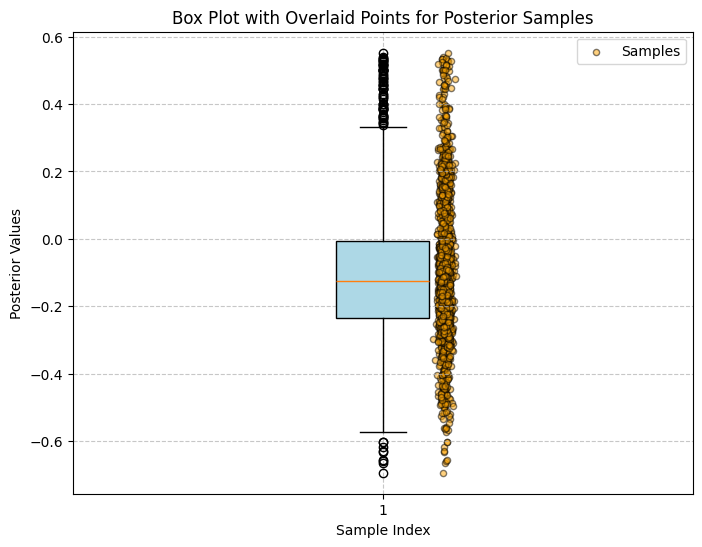

In [15]:
import matplotlib.pyplot as plt
import numpy as np

posterior_values = bart.posterior_f(X_sample)

plt.figure(figsize=(8, 6))
plt.boxplot(posterior_values[0], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(posterior_values.shape[1]):
    y = posterior_values[:, i]
    x = np.random.normal(1.1, 0.005, size=len(y))
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [16]:
eval_single = [float(bart.trace[0].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]
eval_single

C:\Windows\Temp\ipykernel_3360\2762851684.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eval_single = [float(bart.trace[0].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]


[0.004127599815627625,
 0.0058855780246425335,
 0.023699252948074623,
 -0.013974253931047651,
 -0.007731272873357951,
 0.04982850950548378,
 -0.009570554236326434,
 0.03247070593034919,
 -0.015085142153895944,
 0.054129906402008376,
 -0.017605016534487327,
 -0.006594451922395336,
 0.032058287461922824,
 0.0061893951871874065,
 -0.012403858189927248,
 0.018004038778255294,
 0.00805413160928663,
 -0.010008099051897475,
 -0.003975842917860152,
 0.017154484193465682,
 0.06336949541128861,
 -0.009668708246314339,
 0.006696571097770018,
 -0.04434241467340884,
 -0.07019454950741348,
 0.01378524772878989,
 -0.08866916006898992,
 0.014639847389337922,
 0.012225950614268809,
 -0.0476361651071983,
 -0.03201061549870628,
 -0.021559615213105832,
 0.040684283360036745,
 -0.0012540818970127373,
 -0.01280762323522393,
 0.006349183919234063,
 0.006262885858363444,
 0.011849593367366395,
 -0.014338786290463638,
 -0.06165838511733948,
 0.016092167262607846,
 -0.003658984166001482,
 0.026043395663523462,


In [17]:
len(eval_single)

52

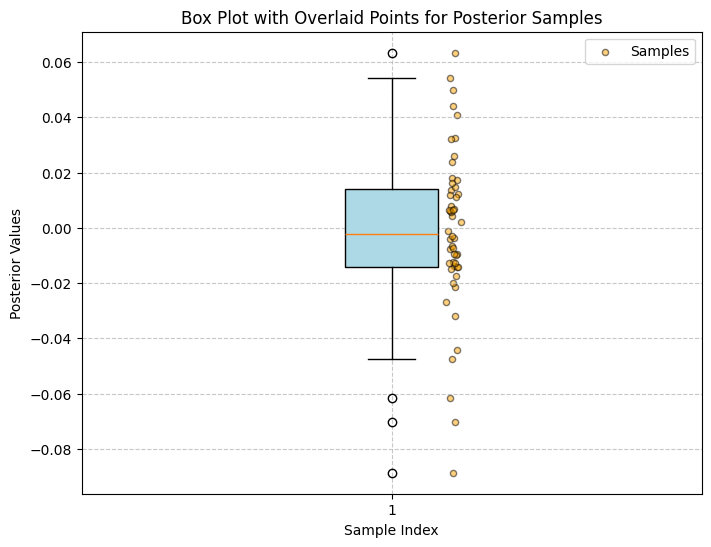

In [18]:
plt.figure(figsize=(8, 6))
plt.boxplot(eval_single, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(len(eval_single)):
    y = eval_single[i]
    x = np.random.normal(1.1, 0.005, size=1)
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [19]:
np.sum(eval_single)

-0.061912524549932166

In [20]:
eval = [bart.trace[i].evaluate(X_sample) for i in range(len(bart.trace))]
eval

[array([-0.06191252]),
 array([-0.05295923]),
 array([-0.08315456]),
 array([-0.09717913]),
 array([-0.08238844]),
 array([-0.04708456]),
 array([-0.09882312]),
 array([-0.09176625]),
 array([-0.09019078]),
 array([-0.09884285]),
 array([-0.08112826]),
 array([-0.07916686]),
 array([-0.00852721]),
 array([-0.01915346]),
 array([-0.00250647]),
 array([-0.03641545]),
 array([-0.05655348]),
 array([-0.07251069]),
 array([-0.05847601]),
 array([-0.07098549]),
 array([-0.09081416]),
 array([-0.06385712]),
 array([-0.05836729]),
 array([-0.03671367]),
 array([-0.04082024]),
 array([0.02490877]),
 array([0.04794758]),
 array([0.05141171]),
 array([0.03720385]),
 array([0.05446434]),
 array([0.08755674]),
 array([0.10149038]),
 array([0.09767756]),
 array([0.11902971]),
 array([0.14075997]),
 array([0.14988646]),
 array([0.15569702]),
 array([0.13163238]),
 array([0.13110531]),
 array([0.15227361]),
 array([0.13357583]),
 array([0.13903849]),
 array([0.08158773]),
 array([0.12922746]),
 array(

In [21]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [22]:
btpred

array([ 0.38446972, -0.32733396, -0.05802381,  0.19546166,  0.5496358 ,
       -0.35113308,  0.24720629,  0.62195385,  0.59026486,  0.42860642,
        0.3862555 ,  0.66385573,  0.5927409 ,  0.42343318,  0.42874578,
        0.4309265 ,  0.56422174,  0.5692703 ,  0.46088928,  0.32252392,
        0.54202056,  0.14312837,  0.48154637,  0.50655997,  0.4694542 ,
        0.4841167 , -0.30366105,  0.43316677,  0.069369  ,  0.16810752,
       -0.00229029,  0.43645528,  0.4042409 ,  0.04630348,  0.563865  ,
        0.42625523,  0.3946725 , -0.42965552,  0.4993285 ,  0.5151506 ],
      dtype=float32)

In [23]:
y_pred = bart.predict(X_test)
y_pred

array([-0.09949367, -0.11699966, -0.09665833, -0.08996649, -0.12159564,
       -0.12234721, -0.11328938, -0.07911925, -0.08579746, -0.10745035,
       -0.07940244, -0.08630482, -0.07982371, -0.09498501, -0.14231319,
       -0.1039342 , -0.15250964, -0.12969806, -0.10986353, -0.10374863,
       -0.13013871, -0.08808887, -0.11110007, -0.11275873, -0.13882232,
       -0.08145614, -0.08850956, -0.08098887, -0.1038459 , -0.06574231,
       -0.08175118, -0.08996108, -0.09648563, -0.10153731, -0.08113968,
       -0.1116181 , -0.07167916, -0.12462439, -0.14786945, -0.13808167])